# Twitter Sentiment Investing Strategy
### 1.Load Twitter Sentiment Data
.Load the twitter sentiment dataset, set the index, calculate engagement ratio and filter out stocks with no significant twitter activity

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import yfinance as yf
import os 
plt.style.use('ggplot')
data_folder=r'C:\Users\Aissa\Downloads\unemployement no more'


In [2]:
sentiment_df= pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))
sentiment_df['date']=pd.to_datetime(sentiment_df['date'])
sentiment_df= sentiment_df.set_index(['date','symbol'])
#to filter out bot activity we will add a feature engagement ratio
#if a post has a lot of likes but not so many comments(likely bot)

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

#twitter likes more than 20 and comments more than 10 otherwise its just noise
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]
sentiment_df                        


twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

### 2.Aggregate Monthly and calculate average sentiment for the month
.Aggregate on a monthly level and calculate average monthly metric, for the one we choose 


In [3]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])
[['engagement_ratio']].mean())
aggragated_df['rank']= (aggragated_df.groupby(level=0)['engagement_ratio']
                        .transform(lambda x: x.rank(ascending=False)))
aggragated_df

C:\Users\Aissa\AppData\Local\Temp\ipykernel_19640\1760081504.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### 3.Select Top 5 Stocks based on their cross-sectional ranking for each month
.Select top 5 stocks by rank for each month and fix the date to start at the beginning of the next month

In [4]:
filtered_df = aggragated_df[aggragated_df['rank']<=5].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df


engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

### 4.Extract the stocks to form portfolios with at the start of each new month
.Create a dictionary containing start of month and corresponded selected stocks.

In [5]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')]=filtered_df.xs(d,level=0).index.tolist()
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### 5.Download fresh stock prices for only selected stocks

In [6]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers= stocks_list,
                       start='2021-01-01',
                       end='2023-03-01',
                       auto_adjust=False)
prices_df

[*********************100%***********************]  85 of 85 completed

2 Failed downloads:
['ATVI', 'MRO']: YFTzMissingError('possibly delisted; no timezone found')


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.095337  15.13  141.919540  126.239708   88.119598  100.580055   
2021-01-05  116.036362  15.43  141.766205  127.800514   89.030807  101.824516   
2021-01-06  119.218353  15.52  149.956268  123.498535   88.261711  101.612503   
2021-01-07  122.390678  15.38  151.237106  127.712692   89.206360  102.598862   
2021-01-08  123.263756  15.13  153.392883  128.815048   89.674492  102.884621   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  139.492401  15.56  136.307053  147.230194  138.443466   98.180710   
2023-02-23  140.591965  15.87  134.779007  147.714676  139.729858   98.046860   
2023-02-24  138.628387  15.56  131.779922  145.055038  140.317917   96.048630   
2023-02-27  139.590530  15.63  133.469269  146.251389  141.760529   95.388931   
2023-02-28  139.384354  15.98  137.578812  145.747131  141.411346   97.253311   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  68.997711  19.842176  145.072235  92.300003  ...  5732800   
2021-01-05  68.904648  20.508137  154.862198  92.769997  ...  4029500   
2021-01-06  69.454674  21.327778  166.429581  90.330002  ...  3612500   
2021-01-07  67.601524  21.114334  174.888855  95.160004  ...  3993700   
2021-01-08  67.000740  21.703451  174.983932  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  83.101845  22.980518  237.693390  76.610001  ...  2044600   
2023-02-23  83.001198  22.980518  244.830460  79.750000  ...  2066600   
2023-02-24  82.744987  22.917160  240.654312  78.089996  ...  2875100   
2023-02-27  82.415581  22.518917  247.887817  78.769997  ...  2459700   
2023-02-28  80.494049  22.337896  245.274109  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

### 6. Calculate Portfolio Returns with monthly rebalancing

In [18]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna(how='all')
portfolio_df=pd.DataFrame()
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols=fixed_dates[start_date]
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df,temp_df],axis=0)
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


### 7.download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [24]:
qqq_df = yf.download(tickers='QQQ',
                     start = '2021-01-01',
                     end= '2023-03-01',
                     auto_adjust= False)
qqq_ret = np.log(qqq_df['Adj Close']).diff()
qqq_ret.columns = ['nasdaq_return']
portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


<function matplotlib.pyplot.show(close=None, block=None)>

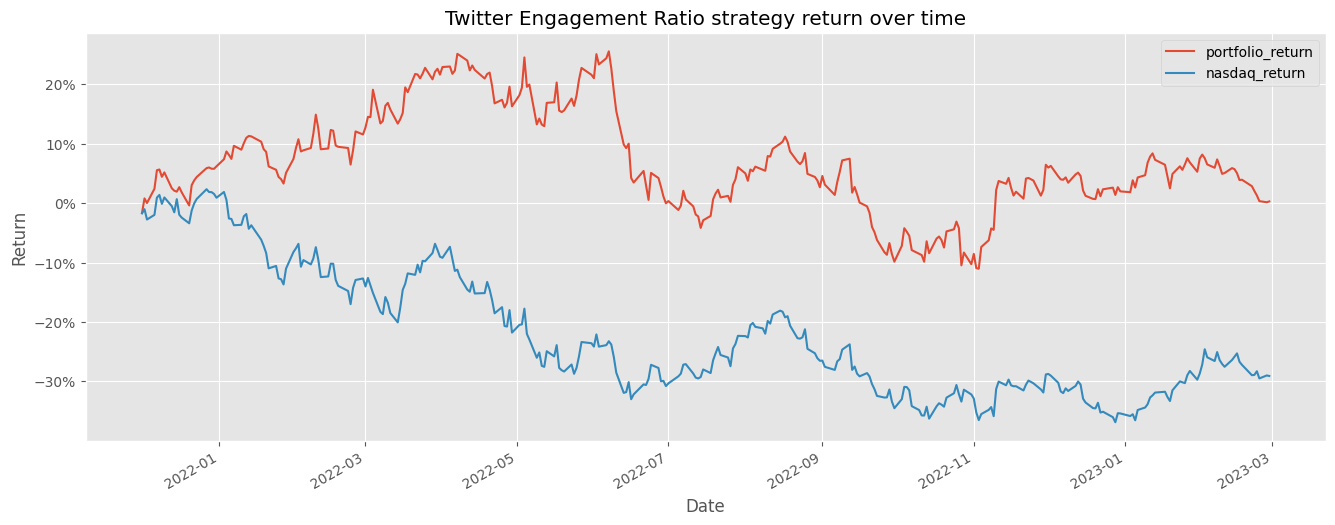

In [27]:
import matplotlib.ticker as mtick
portfolio_cumulative_ret= np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_ret
portfolio_cumulative_ret.plot(figsize=(16,6))
plt.title('Twitter Engagement Ratio strategy return over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show